# Data visualization and pre-processing

## Data visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
import pyarrow.parquet as pq

In [4]:
train_events = pd.read_csv('../data/train_events.csv')

#Read file with chunks
chunksize = 100000
train_series = pq.ParquetFile('../data/train_series.parquet')
for batch in train_series.iter_batches(batch_size=chunksize):
    train_series_chunk = batch.to_pandas()

test_series = pq.read_table('../data/test_series.parquet').to_pandas()

### Train events visualization

In [5]:
train_events

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400
...,...,...,...,...,...
14503,fe90110788d2,33,wakeup,560604.0,2017-09-06T04:07:00-0400
14504,fe90110788d2,34,onset,574620.0,2017-09-06T23:35:00-0400
14505,fe90110788d2,34,wakeup,581604.0,2017-09-07T09:17:00-0400
14506,fe90110788d2,35,onset,NaN,NaN


In [29]:
# Calculer le nombre de valeurs NaN par colonne
nan_counts = train_events.isna().sum()

# Afficher le résultat
print(f"Nombre de valeurs manquantes par colones:\n{nan_counts}")


Nombre de valeurs manquantes par colones:
series_id       0
night           0
event           0
step         4923
timestamp    4923
dtype: int64


In [21]:
num_duplicates = train_events.duplicated().sum()
print(f"Nombre de lignes dupliquées : {num_duplicates}")


Nombre de lignes dupliquées : 0


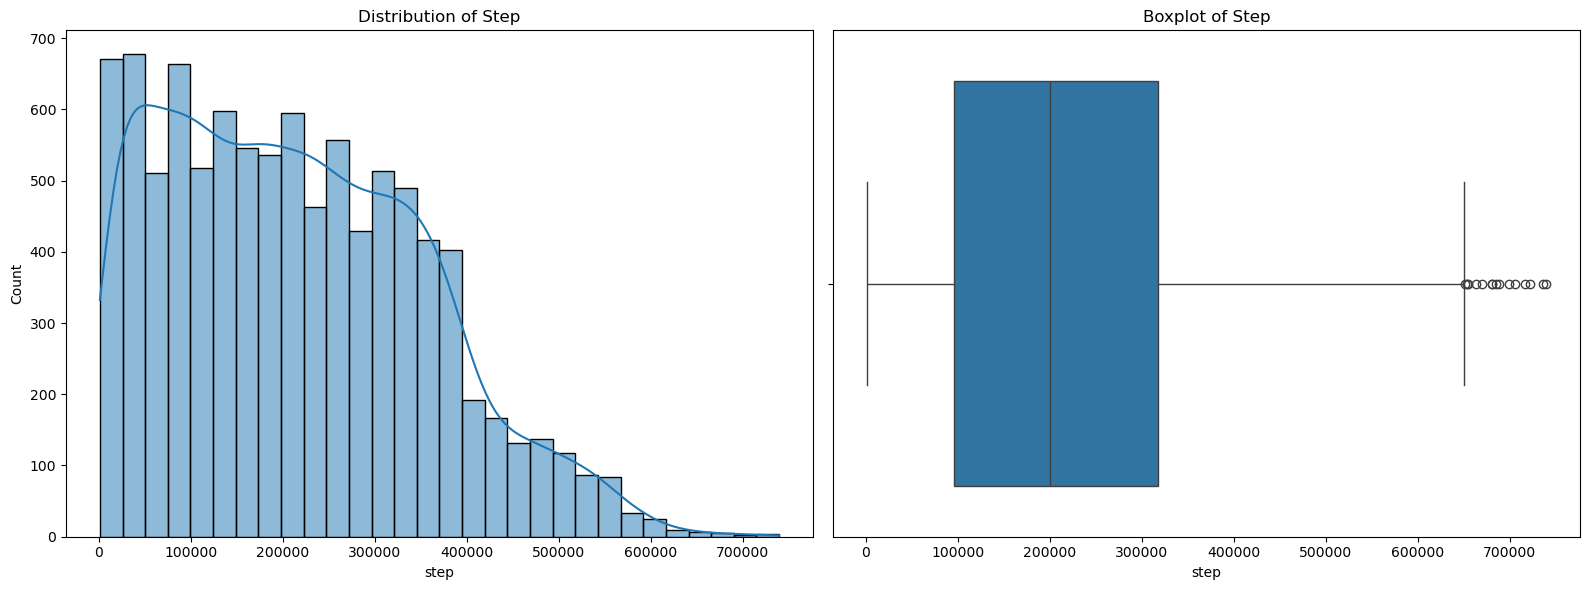

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 ligne, 2 colonnes

# Histogramme pour la colonne "step"
sns.histplot(train_events['step'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Step')

# Boxplot pour identifier les outliers
sns.boxplot(x=train_events['step'], ax=axes[1])
axes[1].set_title('Boxplot of Step')

# Afficher les graphiques
plt.tight_layout()
plt.show()


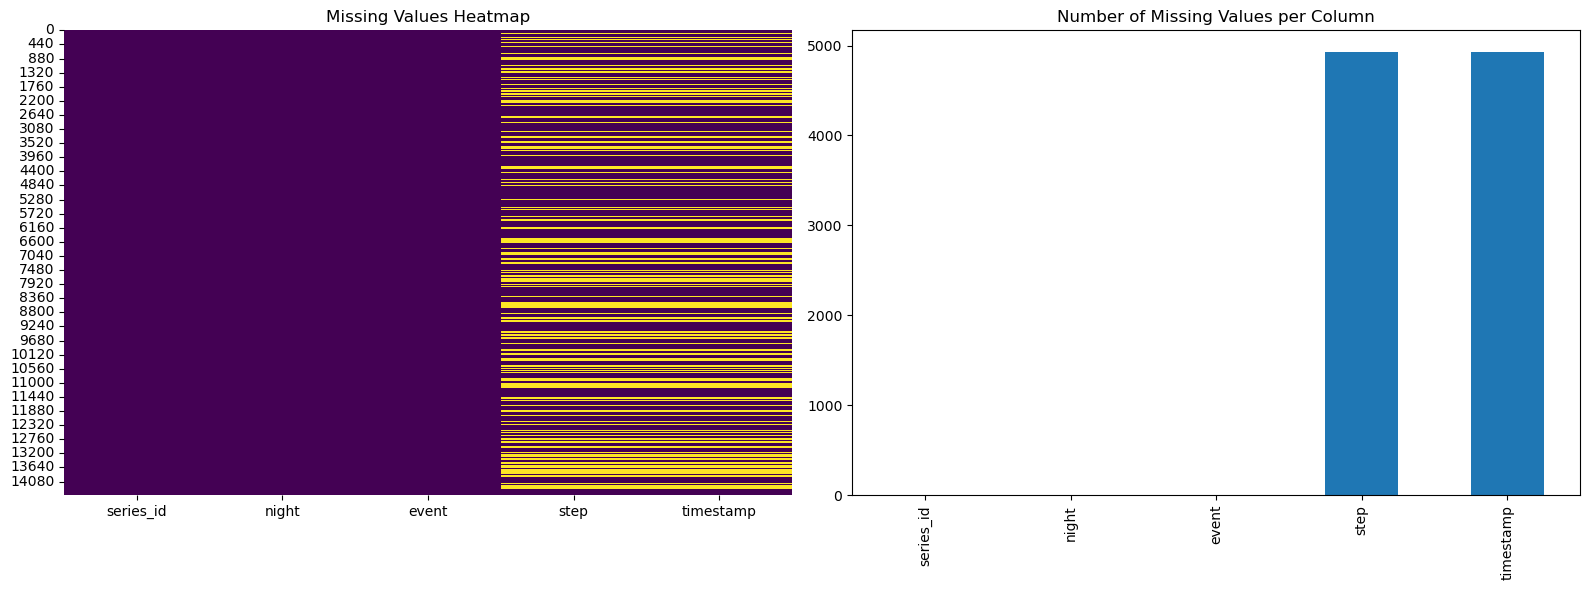

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Visualisation des valeurs manquantes (Heatmap)
sns.heatmap(train_events.isna(), cbar=False, cmap='viridis', ax=axes[0])
axes[0].set_title('Missing Values Heatmap')

# Nombre de valeurs NaN par colonne (Barplot)
train_events.isna().sum().plot(kind='bar', ax=axes[1])
axes[1].set_title('Number of Missing Values per Column')

# Afficher les graphiques
plt.tight_layout()
plt.show()


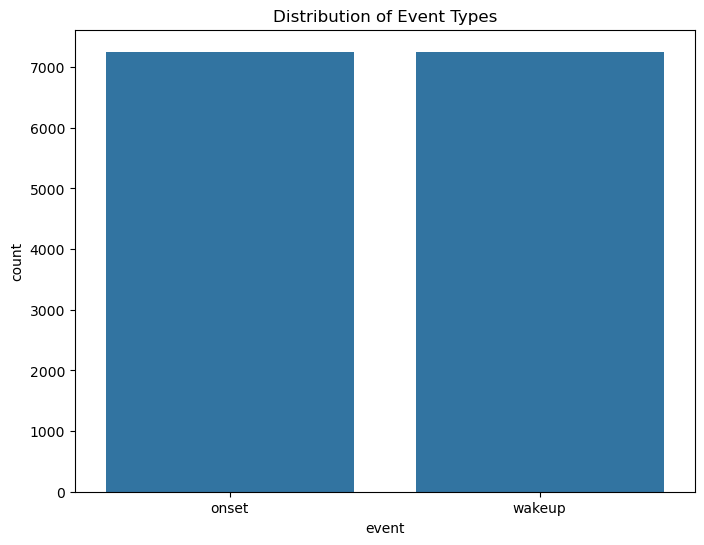

In [30]:
# Compter la fréquence des différents types d'événements
plt.figure(figsize=(8, 6))
sns.countplot(x='event', data=train_events)
plt.title('Distribution of Event Types')
plt.show()